In [139]:
import requests
import time
import random
import pandas as pd
from pyquery import PyQuery as pq
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
def get_url(url_start, page_nums):
    # 获取网站连接
    urls = []
    urls.append(url_start)
    for i in range(2, page_nums+1):
        urls.append(f'{url_start}/p{i}')
    return urls

def get_info(url):
    '''获取租房详细信息，返回的是一个列表'''
    # 获取网页内容
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36 Edg/131.0.0.0'}
    request1 = requests.get(url, headers=headers)
    # 使用 pyquery 解析网页内容
    d = pq(request1.content)
    d = d('div').filter('.zu-itemmod')
    # 提取房源信息
    detail = []
    for i in d.items():
        title = i('h3 b.strongbox').text()  # 房源标题
        rooms = i('p.details-item.tag b.strongbox').eq(0).text()  # 房间数
        halls = i('p.details-item.tag b.strongbox').eq(1).text()  # 厅数
        area = i('p.details-item.tag b.strongbox').eq(2).text()  # 面积
        other = i('p.details-item.bot-tag').text()
        location = i('address.details-item.tag a').text()  # 地点
        price = i('div.zu-side strong.price').text()  # 价格
        unit = i('div.zu-side span.unit').text()  # 单位
        contact = i('span.jjr-info').text()  # 经纪人姓名
        detail.append([title, rooms, halls, other, area, location, price, unit, contact])
    return detail

In [ ]:
url = 'https://zz.zu.anjuke.com/fangyuan/zhengdongxinqu'
urls = get_url(url, 50)

zufang = pd.DataFrame()
for i in urls:
    zufang = pd.concat([zufang, pd.DataFrame(get_info(i))])
    print(f'Page{i} finished!')
    print(zufang.info())
    time.sleep(random.randint(1,2))
    
# 保存数据
zufang.to_csv('anjuke.csv')

In [93]:
# 数据清洗
anjuke = pd.read_csv('anjuke.csv')
# 重新排序
anjuke = anjuke.drop(columns=['Unnamed: 0']).drop(columns='7')
# 详细信息整理
anjuke[['9', '10', '11']] = None
def clean1(ori_data):
    clean_data = []
    split_data = ori_data.split(' ')
    # 地铁
    if '线' in ori_data:
        clean_data.append(split_data[-1])
    else:
        clean_data.append(None)
    # 租房方式
    if '整租' in ori_data:
        clean_data.append('整租')
    elif '合租' in ori_data:
        clean_data.append('合租')
    else:
        clean_data.append('独立单间')
    # 电梯
    if '有电梯' in ori_data:
        clean_data.append('有电梯')
    else:
        clean_data.append('无电梯')
    return clean_data
anjuke['3'] = anjuke['3'].apply(clean1)
for i in range(len(anjuke)):
    anjuke['9'][i] = anjuke['3'][i][0]
    anjuke['10'][i] = anjuke['3'][i][1]
    anjuke['11'][i] = anjuke['3'][i][2]
anjuke = anjuke.drop(columns='3')
# 设置列名
columns = ['标题', '室', '厅', '面积', '小区', '价格', '联系人', '地铁', '出租方式', '电梯']
anjuke.columns = columns
anjuke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   标题      1380 non-null   object 
 1   室       1380 non-null   int64  
 2   厅       1380 non-null   int64  
 3   面积      1380 non-null   float64
 4   小区      1380 non-null   object 
 5   价格      1380 non-null   int64  
 6   联系人     1380 non-null   object 
 7   地铁      1230 non-null   object 
 8   出租方式    1380 non-null   object 
 9   电梯      1380 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 107.9+ KB


In [94]:
anjuke.head()

,标题,室,厅,面积,小区,价格,联系人,地铁,出租方式,电梯
0,双子塔旁 东站附近 东方鼎盛三期 轻奢风格家电齐全随时看房,3,2,30.0,东方鼎盛时代三期,500,李帅旗,1/3/5/12号线,合租,有电梯
1,暖气开放 拎包入住 无杂费 可月付短租 双子塔 升龙 凯丽,3,2,35.0,海马公园(B区),700,马旭龙,1/3/5号线,合租,有电梯
2,绿地老街 建业总部港 宝龙广场 实图实价 拒绝假房源 可短租,3,2,30.0,老街绿地郑东新苑一期,1000,高俊龙,4/5/12号线,合租,有电梯
3,东十里铺双地铁 三号线 精装一居室 无中介费,1,1,46.2,红星美凯龙(商住楼),1400,文世兴,3/4/12号线,整租,有电梯
4,新年新气象！！！优惠多多！福利多多！升龙广场 双子塔 东站,2,2,18.0,海马公园(D区),400,闫浩瑜,1/3/5号线,合租,有电梯


<Axes: title={'center': '价格数据分布'}, xlabel='价格', ylabel='Count'>

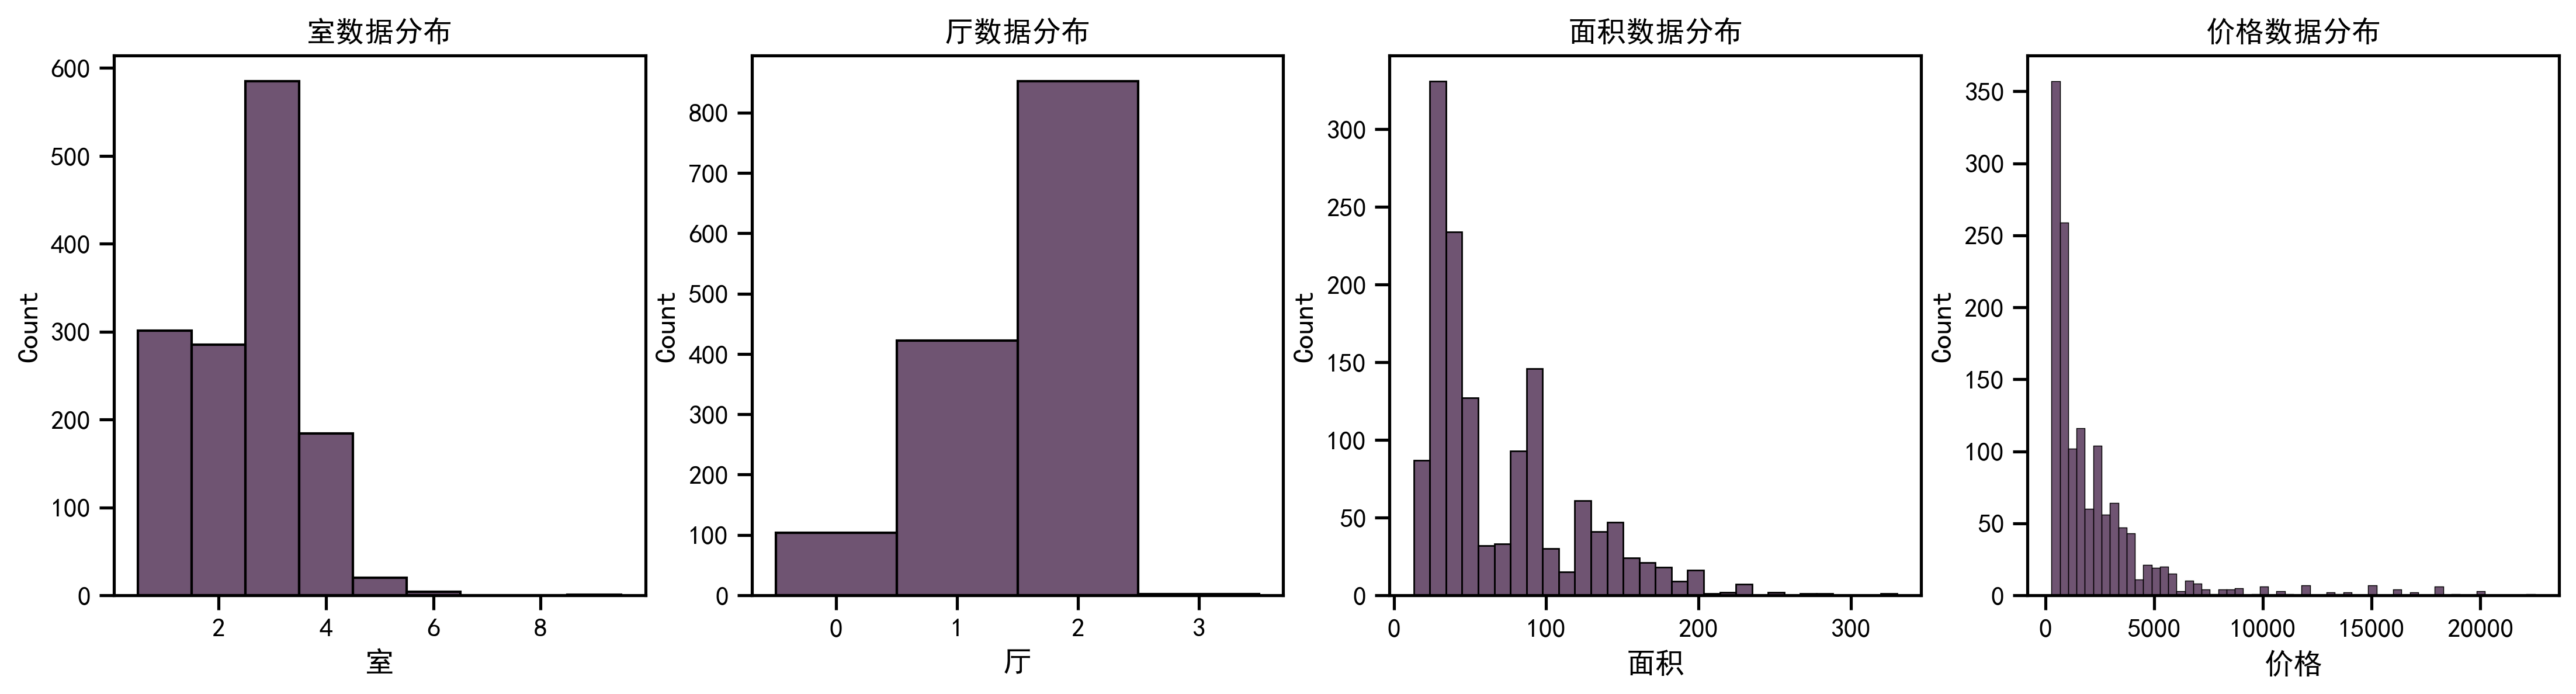

In [179]:
# 数据可视化
plt.figure(figsize=(18, 4), dpi=300)
# 调色板
colors = sns.color_palette('rocket',n_colors=5)
colors2 = sns.color_palette('rocket',n_colors=3)
sns.set_context("notebook")

# 查看各数据分布
plt.subplot(1,4,1)
plt.title('室数据分布')
sns.histplot(x='室', data=anjuke, 
             discrete=True, color=colors[0])
plt.subplot(1,4,2)
plt.title('厅数据分布')
sns.histplot(x='厅', data=anjuke, 
             discrete=True, color=colors[0])
plt.subplot(1,4,3)
plt.title('面积数据分布')
sns.histplot(x='面积', data=anjuke, color=colors[0])
plt.subplot(1,4,4)
plt.title('价格数据分布')
sns.histplot(x='价格', data=anjuke, color=colors[0])

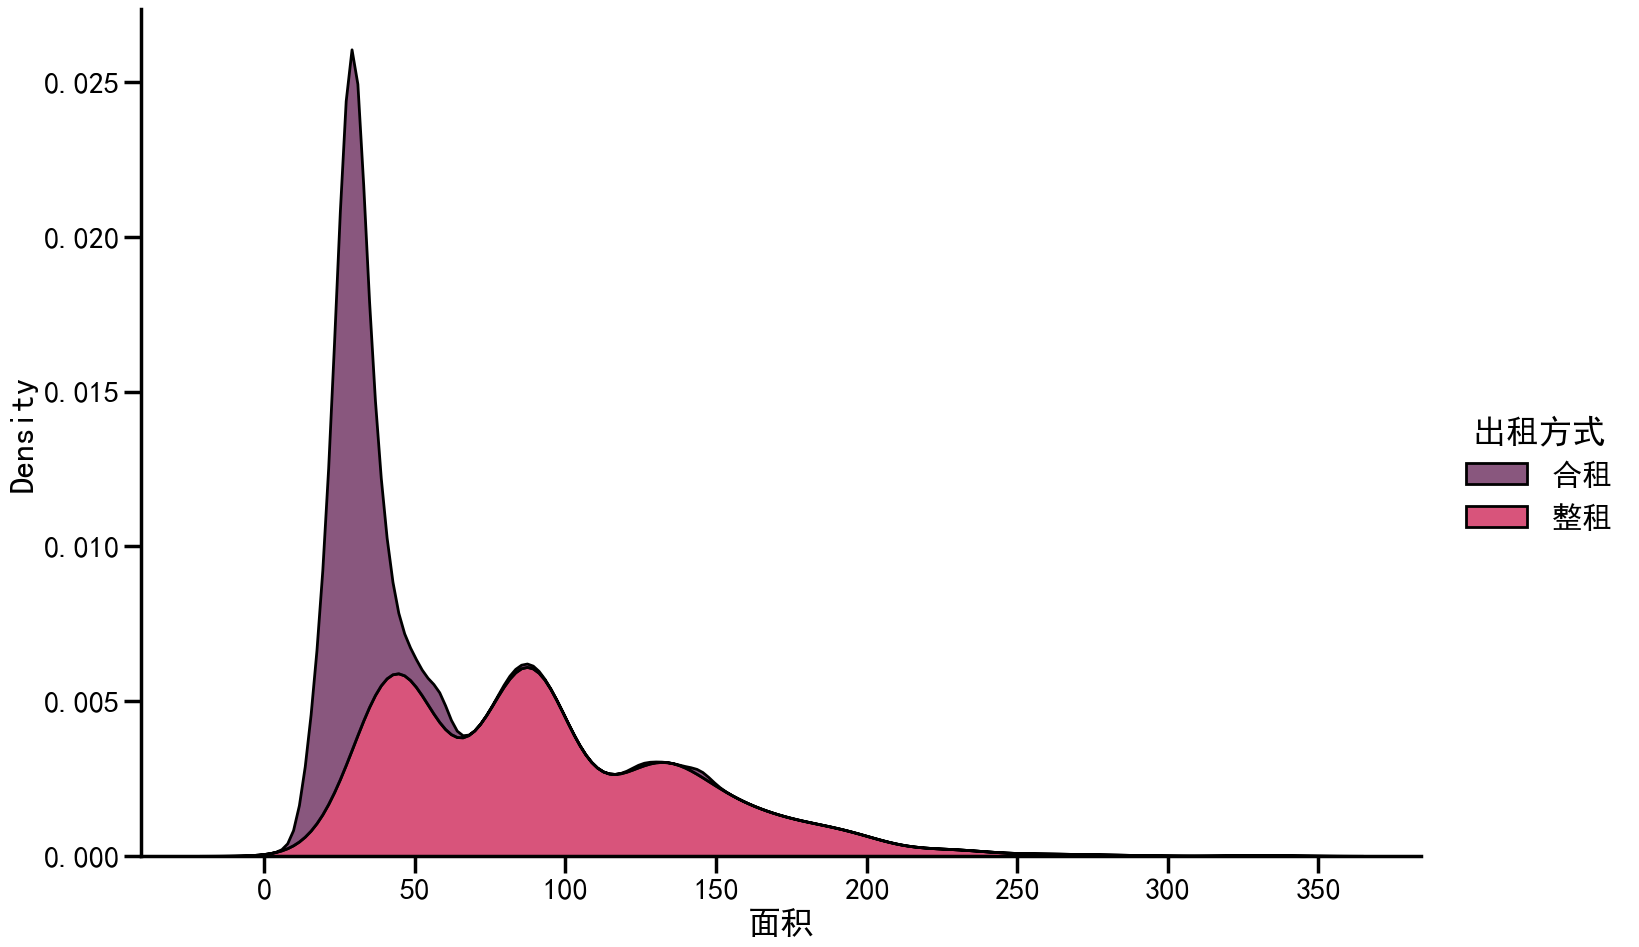

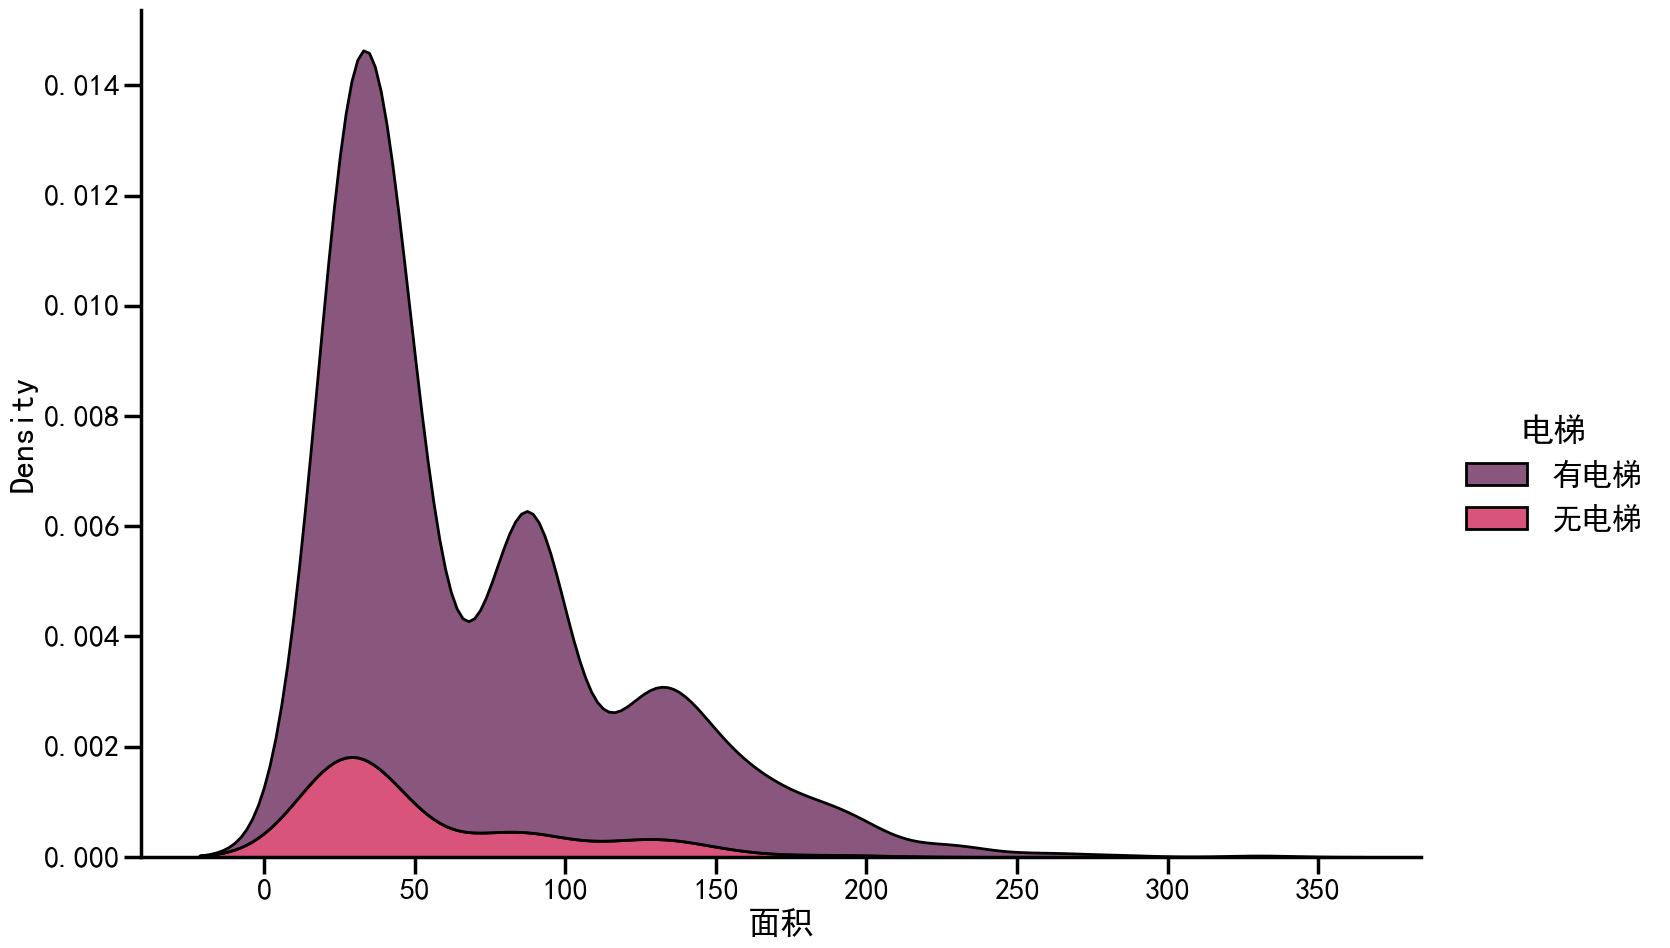

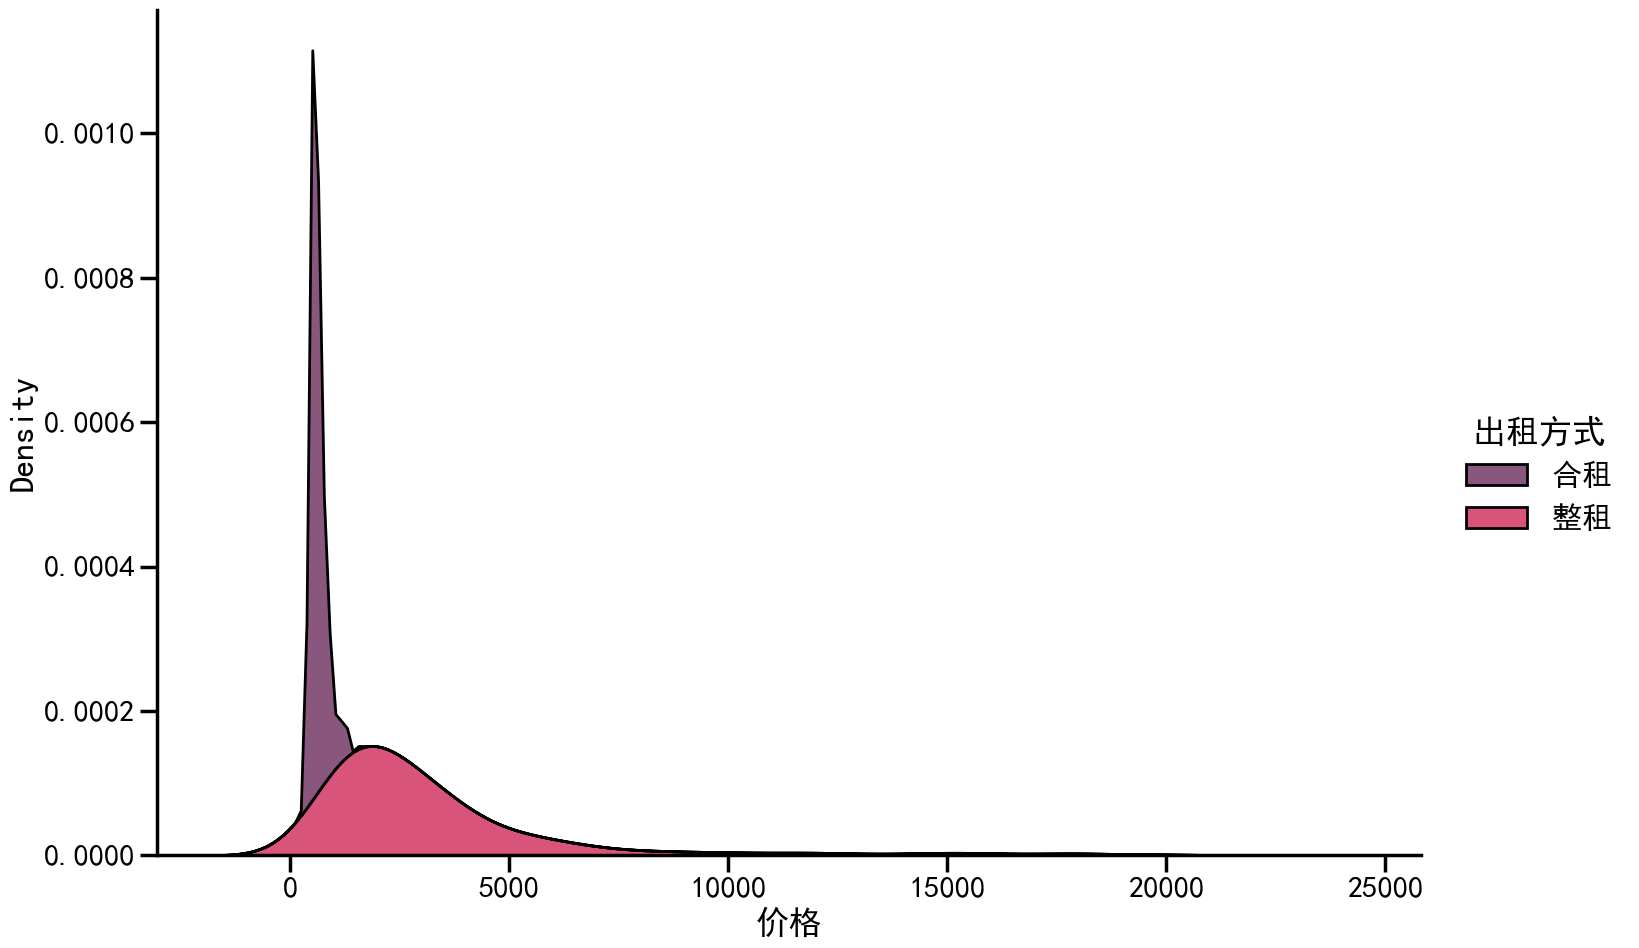

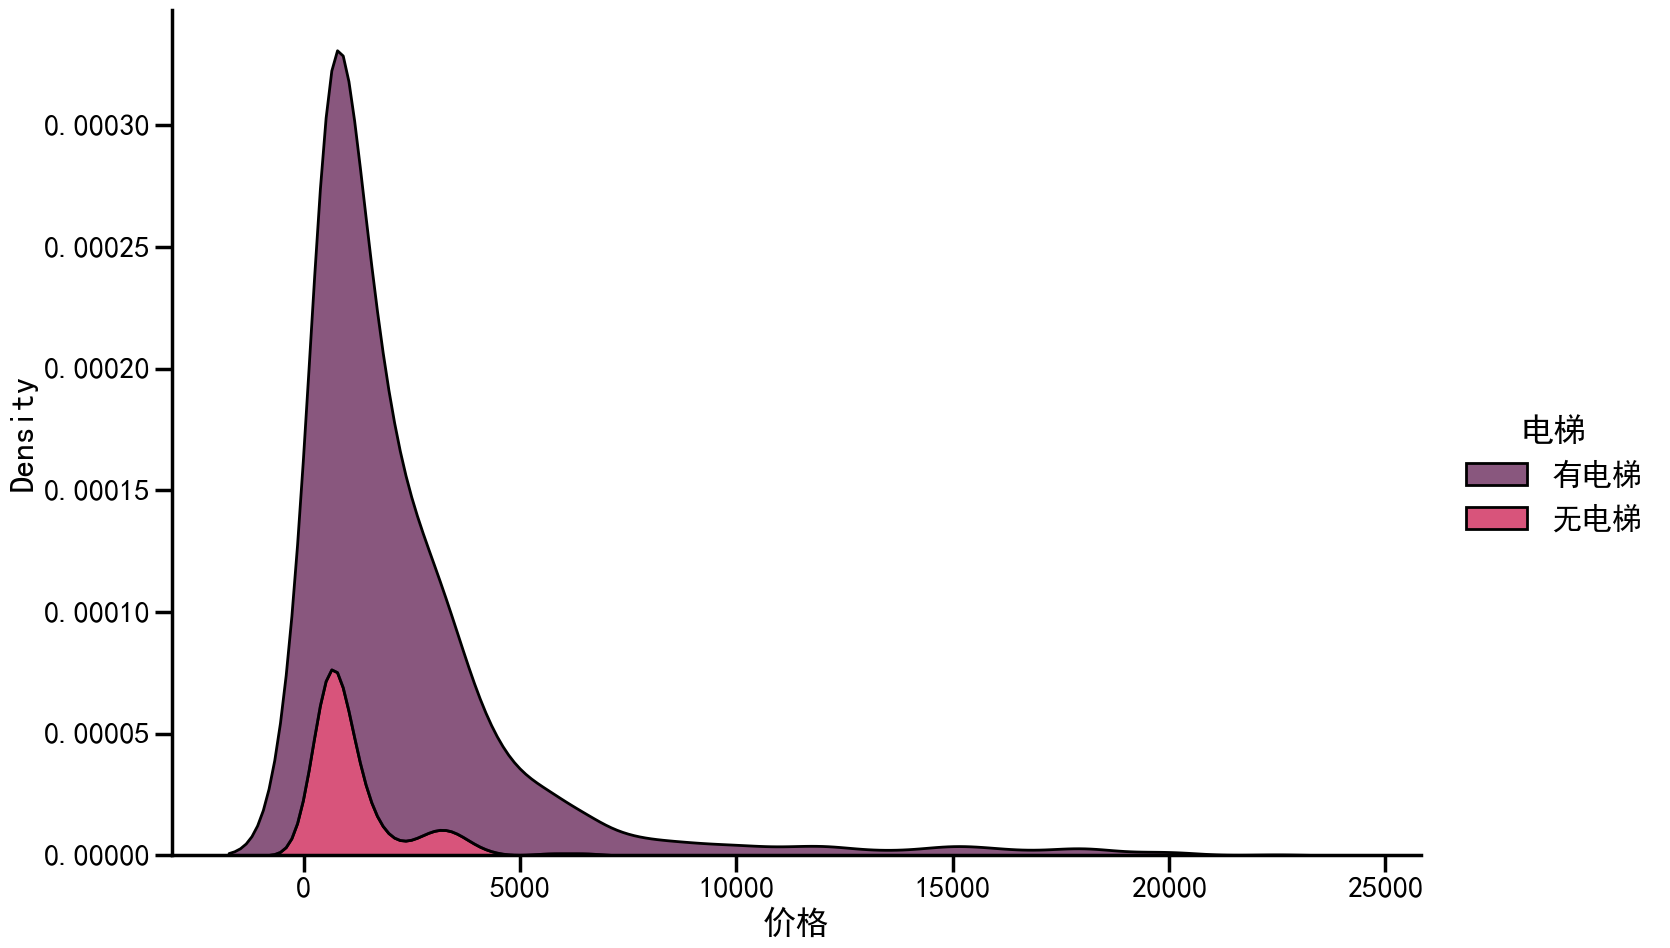

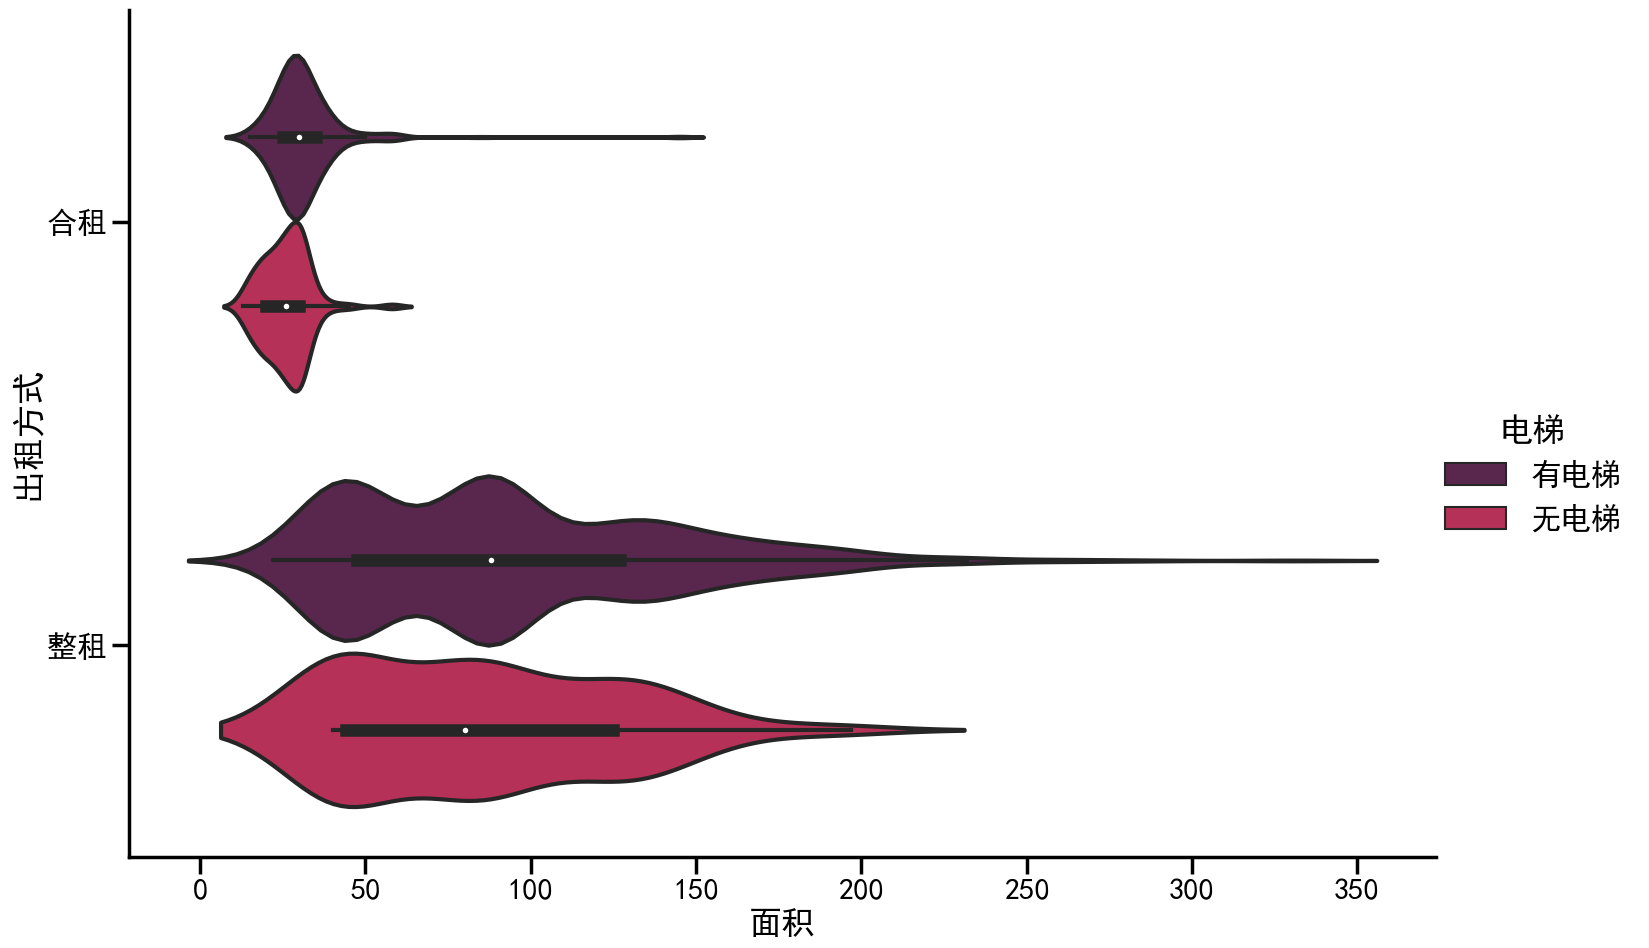

In [176]:
sns.set_context("poster")
sns.displot(x='面积', data=anjuke, hue='出租方式',
            kind='kde', multiple="stack",
            height=10, aspect=1.5, palette=colors2)
sns.displot(x='面积', data=anjuke, hue='电梯',
            kind='kde', multiple="stack",
            height=10, aspect=1.5, palette=colors2)
sns.displot(x='价格', data=anjuke, hue='出租方式',
            kind='kde', multiple="stack",
            height=10, aspect=1.5, palette=colors2)
sns.displot(x='价格', data=anjuke, hue='电梯',
            kind='kde', multiple="stack",
            height=10, aspect=1.5, palette=colors2)

sns.catplot(data=anjuke, x="面积", y="出租方式", hue="电梯",
            kind="violin", height=10, aspect=1.5, palette=colors2)